# Deep Learning

## Assignment 1:

### Question 3:
### Back Propagation, Resilient Propagation (RProp) and Quickprop

In this part of the assignment, we will implement a 3 layered neural network with the given dataset. Let us start by visualising the contents of the data set given to us.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import copy

In [4]:
data = pd.read_excel('Concrete_Data.xls')
df = pd.DataFrame(data)
df.columns = ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate','Age', 'CCS']
print(df.head()) # Print top 5 entries of the data

   Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
0   540.0                 0.0      0.0  162.0               2.5   
1   540.0                 0.0      0.0  162.0               2.5   
2   332.5               142.5      0.0  228.0               0.0   
3   332.5               142.5      0.0  228.0               0.0   
4   198.6               132.4      0.0  192.0               0.0   

   Coarse Aggregate  Fine Aggregate  Age        CCS  
0            1040.0           676.0   28  79.986111  
1            1055.0           676.0   28  61.887366  
2             932.0           594.0  270  40.269535  
3             932.0           594.0  365  41.052780  
4             978.4           825.5  360  44.296075  


Let us visualise how this data looks lile in a pairplot so we can observe the changes we need to make to the data.

If we look at the data in the table, we can see that some attributes have larger values than the others. So that our Neural Network does not show bias towads any one attribute, we will first normalise the data.

In [5]:
Y = df['CCS'].to_numpy() # Obtaining the true values as well as the input attributes in the form of a numpy array
X = df.drop('CCS', axis = 1).to_numpy()

X_mean = np.mean(X, axis = 0) # Mean of data
X_var = np.var(X, axis = 0) # Variance of data

X = (X - X_mean)/np.sqrt(X_var) # Normalisation

print(pd.DataFrame(X).head())

          0         1         2         3         4         5         6  \
0  2.477918 -0.856886 -0.847132 -0.916663 -0.620225  0.863160 -1.217658   
1  2.477918 -0.856886 -0.847132 -0.916663 -0.620225  1.056170 -1.217658   
2  0.491443  0.795533 -0.847132  2.175367 -1.038944 -0.526514 -2.240913   
3  0.491443  0.795533 -0.847132  2.175367 -1.038944 -0.526514 -2.240913   
4 -0.790432  0.678414 -0.847132  0.488805 -1.038944  0.070531  0.647908   

          7  
0 -0.279733  
1 -0.279733  
2  3.553066  
3  5.057677  
4  4.978487  


Now this data looks more uniform and normalized. Now we can safely say the results of our neural network willnot be biased towards any one attribute and that eacch attribute will have equal contribution to the predicted value.

Let us now proceed to make a class which will contain all the relevant functions required to make our 3 layered neural network

In [6]:
class NeuralNet:

    def __init__(self):
        self.params = {'W1':0.0, 'W2':0.0, 'b1':0.0, 'b2':0.0}
        self.gradients = {'dW1':0.0, 'dW2':0.0, 'db1':0.0, 'db2':0.0}
        self.step = {'dW1':0.0, 'dW2':0.0, 'db1':0.0, 'db2':0.0}
        self.prev_gradients = {'dW1':0.0, 'dW2':0.0, 'db1':0.0, 'db2':0.0}
        self.MSE_train = []
        self.MSE_test = []
        self.pred = []

    def tanh(self, X):
        return np.tanh(X) # Tanh activation

    def leaky_relu(self, X):
        return np.maximum(0.01*X, X) # Leaky ReLu activation

    def tanh_der(self, X):
        return 1 - (np.tanh(X)**2) # Derivative of tanh function

    def leaky_relu_der(self, X):
        for i in range(len(X)):
            for j in range(len(X[0])):
                X[i][j] = 0.01 if X[i][j] <= 0 else 1
        
        return X

    def split_train_test(self, X, Y, i):
        i = i*len(X)
        X_train = X[:int(i), :] # Split data
        Y_train = Y[:int(i)]
        X_test = X[int(i):, :]
        Y_test = Y[int(i):]

        return X_train, Y_train, X_test, Y_test

    def Shuffle(self, X, Y):
        p = np.random.permutation(len(X))
        return X[p], Y[p]

    def initialization(self, n_input, n_hidden, n_output):
        self.params['W1'] = np.random.rand(n_hidden, n_input) # initialising weights randomly
        self.params['W2'] = np.random.rand(n_output, n_hidden)
        self.params['b1'] = np.zeros((n_hidden, 1)) # initialising biases to 0
        self.params['b2'] = np.zeros((n_output, 1))

        self.prev_gradients['dW1'] = np.zeros((n_hidden, n_output))
        self.prev_gradients['dW2'] = np.zeros((n_output, n_hidden))
        self.prev_gradients['db1'] = np.zeros((n_hidden, 1))
        self.prev_gradients['db2'] = np.zeros((n_output, 1))

        self.step['dW1'] = np.absolute(np.random.rand(n_hidden, n_input)) # initialising step size for weights randomly for Rprop and Quickprop
        self.step['dW2'] = np.absolute(np.random.rand(n_output, n_hidden))
        self.step['db1'] = np.absolute(np.random.rand(n_hidden, 1)) # initialising step size for biases randomly for Rprop and Quickprop
        self.step['db2'] = np.absolute(np.random.rand(n_output, 1))

    def forward_prop(self, input, activation):
        Z1 = np.dot(self.params['W1'], input.T) + self.params['b1'] # Forward propagation
        A1 = activation(Z1)
        Z2 = np.dot(self.params['W2'], A1) + self.params['b2']

        cache = (Z1, Z2, A1)
        return Z2, cache

    def MSELoss(self, Z2, Y):
        m = len(Y)
        return np.sum((Z2 - Y)**2)/m # Computing Mean squared error

    def backward_prop(self, cache, activation_der, X, Y):
        Z1, Z2, A1 = cache
        m = len(Y)

        dZ2 = 2*(Z2 - Y)
        self.gradients['dW2'] = np.dot(dZ2, A1.T)/m # Obtaining derivatives
        self.gradients['db2'] = np.sum(dZ2, axis = 1, keepdims = True)/m

        dZ1 = np.dot(self.params['W2'].T, dZ2)*activation_der(Z1)
        self.gradients['dW1'] = np.dot(dZ1, X)/m
        self.gradients['db1'] = np.sum(dZ1, axis = 1, keepdims = True)/m

    def BackProp(self, lr, beta, epoch):
        self.params['W1'] -= lr*self.gradients['dW1'] # Optimizing by using the simple back prop method
        self.params['W2'] -= lr*self.gradients['dW2'] 
        self.params['b1'] -= lr*self.gradients['db1']
        self.params['b2'] -= lr*self.gradients['db2']

    def RProp(self, lr, beta, epoch):
        if epoch == 0:
            for param in self.params.keys(): # Implementing the Rprop algorithm for gradient descent
                self.prev_gradients['d'+param] = copy.deepcopy(self.gradients['d'+param])
                self.step['d'+param] = self.step['d'+param]*np.sign(self.prev_gradients['d'+param])
                self.params[param] -= self.step['d'+param]

        else:
            for param in self.params.keys():
                for i in range(len(self.params[param])):
                    for j in range(len(self.params[param][0])):

                        if (np.sign(self.prev_gradients['d'+param][i][j]) == np.sign(self.gradients['d'+param][i][j])):
                            self.step['d'+param][i][j] = self.step['d'+param][i][j]*lr
                            self.prev_gradients['d'+param][i][j] = copy.deepcopy(self.gradients['d'+param][i][j])

                        else:
                            self.params[param][i][j] += self.step['d'+param][i][j]
                            self.step['d'+param][i][j] = self.step['d'+param][i][j]*beta

                        self.params[param][i][j] -= self.step['d'+param][i][j]

    def QuickProp(self, lr, beta, epoch):
        if epoch == 0:
            for param in self.params.keys():# Implementing the Quick prop algorithm for gradient descent
                self.prev_gradients['d'+param] = copy.deepcopy(self.gradients['d'+param])
                self.step['d'+param] = copy.deepcopy(self.gradients['d'+param])
                self.params[param] = self.params[param] - self.step['d'+param]

        else:
            for param in self.params.keys():  
                self.step['d'+param] = lr*self.step['d'+param]*self.gradients['d'+param]/(self.prev_gradients['d'+param] - self.gradients['d'+param] + beta)
                self.params[param] = self.params[param] - self.step['d'+param]
                self.prev_gradients['d'+param] = copy.deepcopy(self.gradients['d'+param])

       
    def train(self, lr, beta, epochs, n_input, n_hidden,  n_output,activation, activation_der, X_train, Y_train, X_test, Y_test, optimization):
       
        self.initialization(n_input, n_hidden, n_output) # Initializing the weights and biases
        self.MSE_train = []
        self.MSE_test = []
        self.pred = []

        print(f'Training for n_hidden = {n_hidden} and activation = {activation.__name__}')
        for epoch in tqdm.tqdm(range(int(epochs)), desc = 'Training and testing'):
            X_train, Y_train = self.Shuffle(X_train, Y_train)
            
            Y_pred_train, cache = self.forward_prop(X_train, activation) # Computing forward prop
            Y_pred_test, _ = self.forward_prop(X_test, activation)
            self.pred.append(Y_pred_train)

            MSELoss = self.MSELoss(Y_pred_train, Y_train) # Getting the Train MSE loss for this Epoch
            self.MSE_train.append(MSELoss/100) # storing scaled MSELosses

            MSELoss = self.MSELoss(Y_pred_test, Y_test) # Getting the Train MSE loss for this Epoch
            self.MSE_test.append(MSELoss/100)

            self.backward_prop(cache, activation_der, X_train, Y_train) # computing backward prop

            optimization(lr, beta, epoch) #Applying optimization
    
        return 
            
   

We have implemented the class for our Neural network above. Now let us test it with our given data with 4 different implementations given to us in the assignment. We will start by training with back prop

In [7]:
np.random.seed(42)
model = NeuralNet()
X_train, Y_train, X_test, Y_test = model.split_train_test(X, Y, 0.7) # Splitting the test and train

--------------------------------------------------------------------
Training for n_hidden = 25 and activation = tanh


Training and testing: 100%|██████████| 1000/1000 [00:00<00:00, 1906.75it/s]


The minimum MSEloss for train is: 0.37166539972471196
-----
The minimum MSEloss for test is: 0.48753759726344337
--------------------------------------------------------------------
Training for n_hidden = 25 and activation = leaky_relu


Training and testing: 100%|██████████| 1000/1000 [00:19<00:00, 50.99it/s]


The minimum MSEloss for train is: 1.0595519929189219
-----
The minimum MSEloss for test is: 1.1607452796105193
--------------------------------------------------------------------
Training for n_hidden = 50 and activation = tanh


Training and testing: 100%|██████████| 1000/1000 [00:01<00:00, 864.69it/s]


The minimum MSEloss for train is: 0.383017421016464
-----
The minimum MSEloss for test is: 0.43768102843640955
--------------------------------------------------------------------
Training for n_hidden = 50 and activation = leaky_relu


Training and testing: 100%|██████████| 1000/1000 [00:34<00:00, 28.67it/s]


The minimum MSEloss for train is: 0.7153785918457176
-----
The minimum MSEloss for test is: 1.0238712070873253


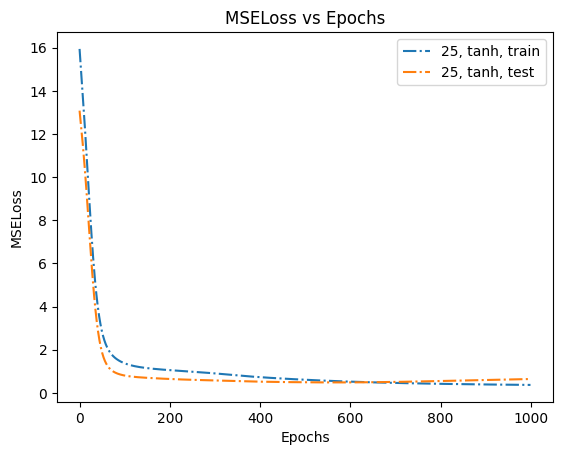

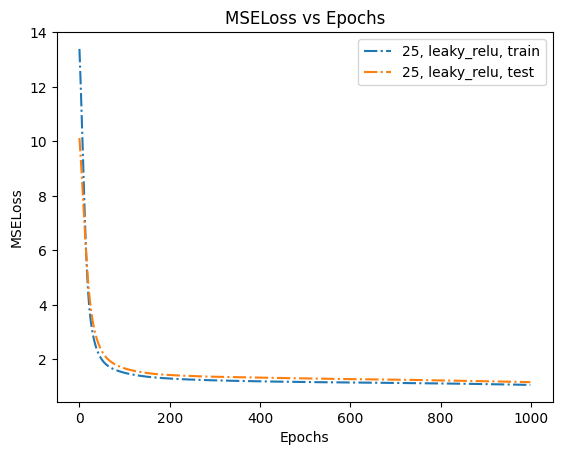

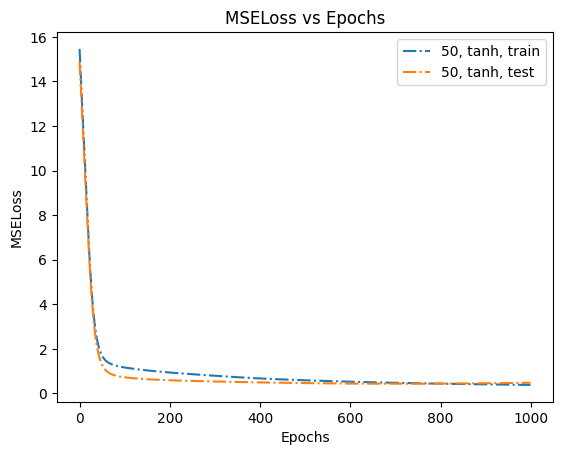

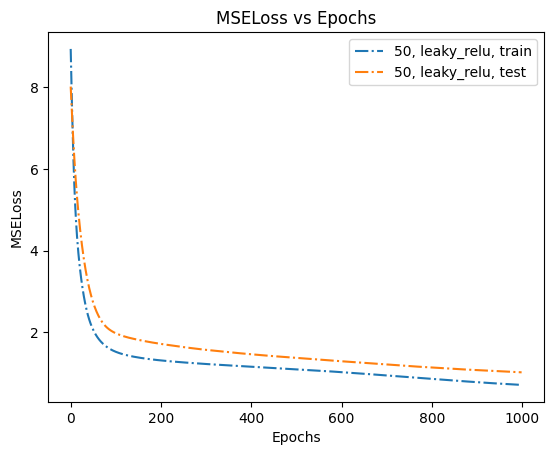

In [22]:

lr = 1e-3 # Setting the hyper parameters
beta = 1e-4
epochs = 1e3
n_input = 8
n_output = 1
n_hidden = [25, 50]
activation = [model.tanh, model.leaky_relu]
activation_der = [model.tanh_der, model.leaky_relu_der]
optimization = model.BackProp


for i in n_hidden:
    for j in range(2):
        print('--------------------------------------------------------------------') 
        model.train(lr, beta, epochs, n_input, i, n_output, activation[j], activation_der[j], X_train, Y_train, X_test, Y_test, optimization)
        plt.figure()
        plt.plot(range(int(epochs)) ,model.MSE_train, '-.',label = f'{i}, {activation[j].__name__}, train')
        print(f'The minimum MSEloss for train is: {np.min(model.MSE_train)}')
        print('-----')
        plt.plot(range(int(epochs)) ,model.MSE_test, '-.',label = f'{i}, {activation[j].__name__}, test')
        print(f'The minimum MSEloss for test is: {np.min(model.MSE_test)}')

        plt.xlabel('Epochs')
        plt.ylabel('MSELoss')
        plt.title('MSELoss vs Epochs')
        plt.legend()


plt.show()
            

In [23]:
pred, _ = model.forward_prop(X_train, model.tanh)
print('predictions:', pred[:, :5])
print('True values:', Y_train[:5])

predictions: [[15.12172175 15.59370272 14.43277718 19.69898123 26.00881644]]
True values: [79.98611076 61.88736576 40.26953526 41.05277999 44.2960751 ]


We can observe the above graphs for BackProp. Here, we see that the least Loss is obtained for 50 hidden units and tanh activation function. Irresepective of hidden nodes, we can infere that tanh does better than the leaky relu function as an activation function.

We can also obsereve for this optimization trick, the Loss decreases drastically for the first 150 epochs and from then on it decreases slowly. The inference time for hidden units 50 is more than for hidden units for 25 as computation of matrices is more heavier for more hidden nodes. We also see that the Loss for unseen data is a little more than the Loss for the train data which shows that the model did not overfit and has learnt the regression well.

Let us perform the above with the other 2 optimization tricks and observe what differences they make.

--------------------------------------------------------------------
Training for n_hidden = 25 and activation = tanh


Training and testing: 100%|██████████| 1000/1000 [00:03<00:00, 296.51it/s]


The minimum MSEloss for train is: 5.564944760927087
-----
The minimum MSEloss for test is: 5.887527121125703
--------------------------------------------------------------------
Training for n_hidden = 25 and activation = leaky_relu


Training and testing: 100%|██████████| 1000/1000 [00:19<00:00, 50.59it/s]


The minimum MSEloss for train is: 1.8566331227858555
-----
The minimum MSEloss for test is: 2.149980248228077
--------------------------------------------------------------------
Training for n_hidden = 50 and activation = tanh


Training and testing: 100%|██████████| 1000/1000 [00:06<00:00, 146.19it/s]


The minimum MSEloss for train is: 2.594190704349163
-----
The minimum MSEloss for test is: 2.97676636956143
--------------------------------------------------------------------
Training for n_hidden = 50 and activation = leaky_relu


Training and testing: 100%|██████████| 1000/1000 [00:43<00:00, 23.21it/s]


The minimum MSEloss for train is: 2.151841621453237
-----
The minimum MSEloss for test is: 2.681852253340427


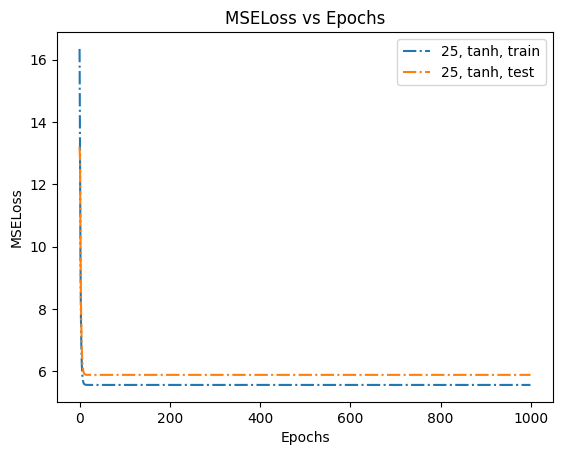

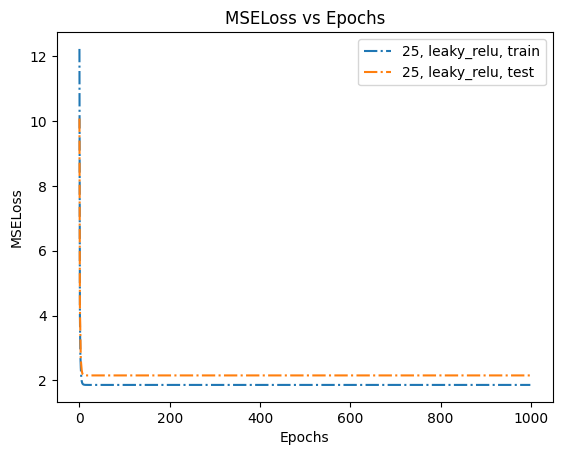

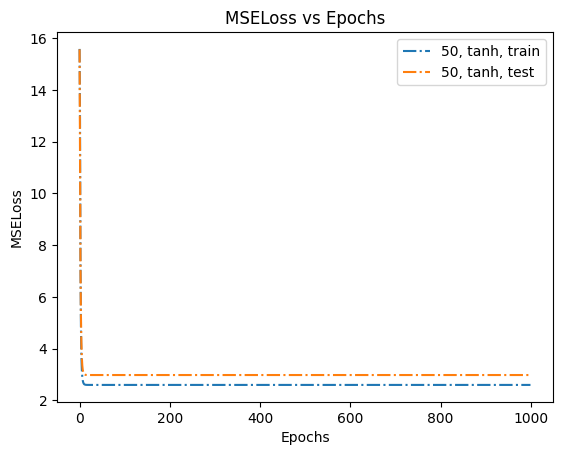

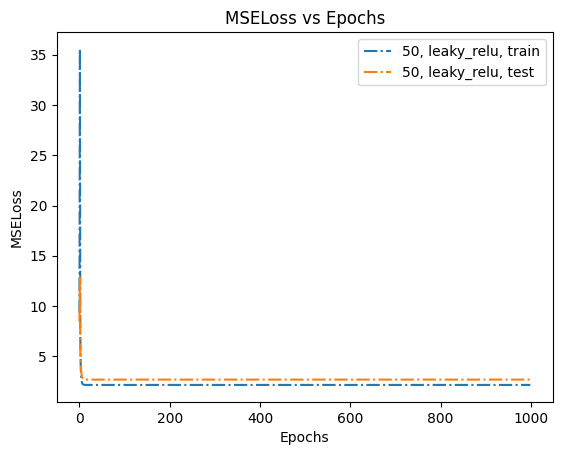

In [25]:
model = NeuralNet()

optimization = model.RProp
epochs = 1000
lr = 0.5
beta = 0.6



for i in n_hidden:
    for j in range(2):
        print('--------------------------------------------------------------------') 
        model.train(lr, beta, epochs, n_input, i, n_output, activation[j], activation_der[j], X_train, Y_train, X_test, Y_test, optimization)
        plt.figure()
        plt.plot(range(int(epochs)) ,model.MSE_train, '-.',label = f'{i}, {activation[j].__name__}, train')
        print(f'The minimum MSEloss for train is: {np.min(model.MSE_train)}')
        print('-----')

        plt.plot(range(int(epochs)) ,model.MSE_test, '-.',label = f'{i}, {activation[j].__name__}, test')
        print(f'The minimum MSEloss for test is: {np.min(model.MSE_test)}')

        plt.xlabel('Epochs')
        plt.ylabel('MSELoss')
        plt.title('MSELoss vs Epochs')
        plt.legend()


plt.show()
            

Above are the plots we obtain for the Rprop method of optimization. As we can see, the loss function is better for 50 hidden nodes in general. Also the tanh activation does a little better than the leaky_relu function.

We can also see that the number of epochs it takes to converge to its best Loss is also very less. Running it for less than 100 epochs will also give us the same results. The inference speed of this particular method is more as the descent alogrithm has alot more complexity.This algorithm is how ever very parameter sensitive. Vhanging the beta values a little bit can give us different results. The parameters chosen for the above give the best results so far. We were also required to change the given learning rate (1e-3) to obtain desired results.

Now let us analyze the Quick prop method.

In [26]:
pred, _ = model.forward_prop(X_train, model.tanh)
print('predictions:', pred[:, :5])
print('True values:', Y_train[:5])

predictions: [[ 1.48159451  2.13138571  7.05576862 10.6898814  12.14447423]]
True values: [79.98611076 61.88736576 40.26953526 41.05277999 44.2960751 ]


--------------------------------------------------------------------
Training for n_hidden = 25 and activation = tanh


Training and testing: 100%|██████████| 1000/1000 [00:00<00:00, 1704.23it/s]


The minimum MSEloss for train is: 0.7120410286945094
-----
The minimum MSEloss for test is: 0.8111969463652023
--------------------------------------------------------------------
Training for n_hidden = 25 and activation = leaky_relu


Training and testing: 100%|██████████| 1000/1000 [00:18<00:00, 54.36it/s]


The minimum MSEloss for train is: 4.760711298502346
-----
The minimum MSEloss for test is: 3.9496005663258837
--------------------------------------------------------------------
Training for n_hidden = 50 and activation = tanh


Training and testing: 100%|██████████| 1000/1000 [00:00<00:00, 1105.38it/s]


The minimum MSEloss for train is: 0.8920105013220201
-----
The minimum MSEloss for test is: 0.5985354456767339
--------------------------------------------------------------------
Training for n_hidden = 50 and activation = leaky_relu


Training and testing: 100%|██████████| 1000/1000 [00:35<00:00, 27.80it/s]


The minimum MSEloss for train is: 1.282741488808264
-----
The minimum MSEloss for test is: 1.581323568047244


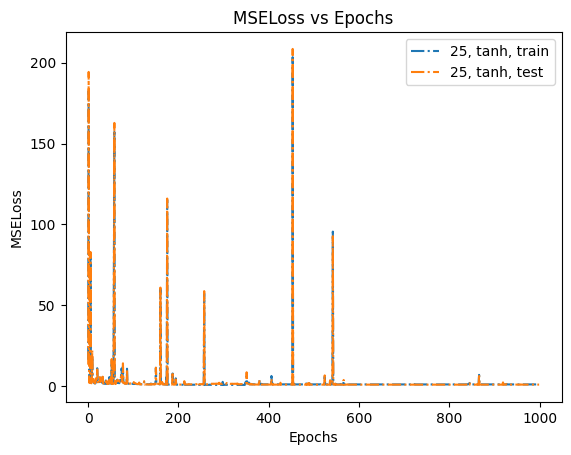

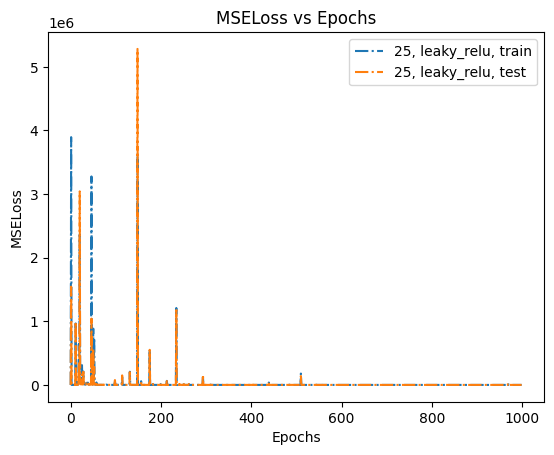

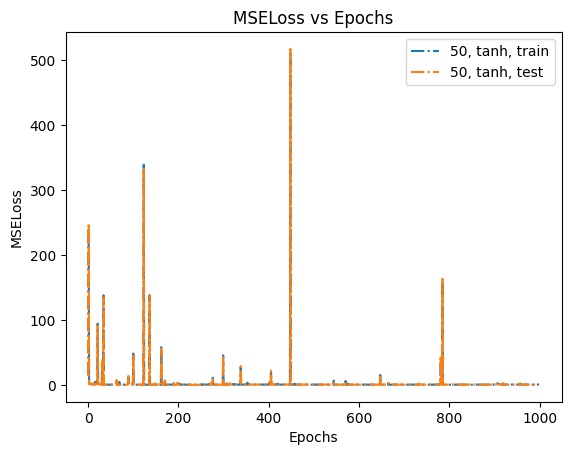

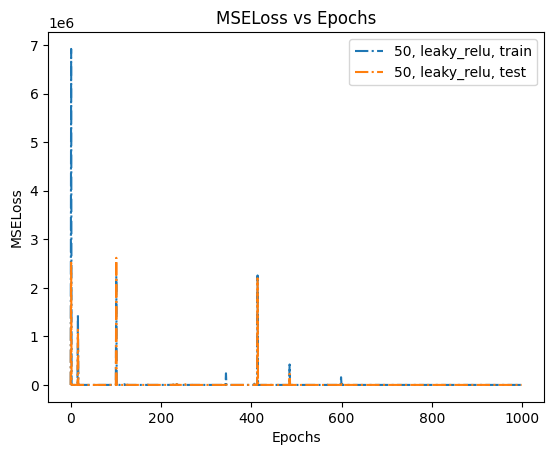

In [27]:
model = NeuralNet()

optimization = model.QuickProp
epochs = 1000
lr = 1
beta = 0.0000000000000000001

for i in n_hidden:
    for j in range(2):
        print('--------------------------------------------------------------------') 
        
        model.train(lr, beta, epochs, n_input, i, n_output, activation[j], activation_der[j], X_train, Y_train, X_test, Y_test, optimization)
        plt.figure()
        plt.plot(range(int(epochs)) ,model.MSE_train, '-.',label = f'{i}, {activation[j].__name__}, train')
        print(f'The minimum MSEloss for train is: {np.min(model.MSE_train)}')
        print('-----')
        plt.plot(range(int(epochs)) ,model.MSE_test, '-.',label = f'{i}, {activation[j].__name__}, test')
        print(f'The minimum MSEloss for test is: {np.min(model.MSE_test)}')

        plt.xlabel('Epochs')
        plt.ylabel('MSELoss')
        plt.title('MSELoss vs Epochs')
        plt.legend()


plt.show()
            

We can see that Quick prop is similar to RProp, but its run time is fairly quicker as it simplifies the process of getting the step size. It also converges to a better value than the Rprop.

Comparing the 3 methods, QuickProp and RProp converge at a lesser epoch than BackProp does.
The minimum loss for BacProp, and QuickProp is lesser than that of RProp.
The order of inference time as can be seen from the above implementation from lowest to highest is, BackProp, QuickProp and the longest time is taken by RProp.

Over all I feel that BackProp is still the better method as it converges quicker and at a better Loss than the other 2 methods. I wouldnt prefer Quick prop method because of its unpredictable step taken. 

In [28]:
pred, _ = model.forward_prop(X_train, model.tanh)
print('predictions:', pred[:, :5])
print('True values:', Y_train[:5])

predictions: [[ -3.97773674  -5.59734791 -17.81543923 -15.53396621 -11.814744  ]]
True values: [79.98611076 61.88736576 40.26953526 41.05277999 44.2960751 ]
